## Imports

In [27]:
import pandas as pd
#import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.io import output_notebook
output_notebook()

import plotly.express as px

import seaborn as sns


Loading BokehJS ...

## Parameter setup

In [ ]:
years = []
for f in range(2003,2022):
    years.append(str(f))

col_to_drop = ["NBN Atlas record ID","Licence","Rightsholder","Occurrence status","Taxon author","Taxon Rank","Country","Recorder","Dataset ID","Data provider","Dataset name","Data provider ID"]

## Import Data

In [458]:
dw = pd.read_csv( 'Data/records-2022-11-02.csv',parse_dates=["Start date"])

## Data Cleanse

In [459]:
# Drop columns we don't need
dw = dw.drop(col_to_drop, axis='columns', errors='ignore')
# drop empty columns
dw = dw.dropna(axis='columns', how='all') 

In [464]:
null_plot = dw.isna().sum()
null_plot = null_plot[null_plot > 0]
null_plot = null_plot.sort_values()
px.bar(null_plot, orientation='h',text_auto=True, title='Missing data').update_layout(yaxis_title='Column', xaxis_title='Count', showlegend=False)

In [469]:
# Fill missing counts with 1
dw['Individual count'] = dw['Individual count'].fillna(1)
# Reduce outliers to 1
dw.loc[dw['Individual count'] > 100, 'Individual count'] = 1

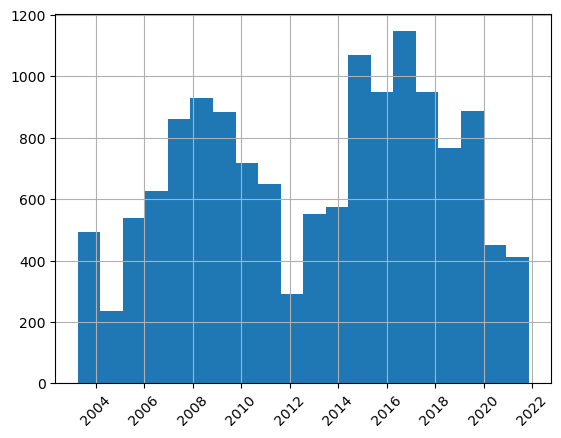

In [473]:
dw['Start date'].hist(bins=20,xrot=45)
plt.show()

In [475]:
px.histogram(dw, x='Start date', nbins=20, orientation='v',text_auto=True).update_layout(yaxis_title='Observations', xaxis_title='', showlegend=False)

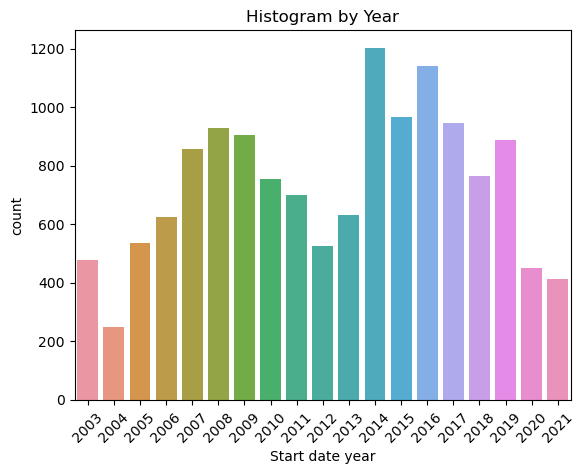

In [313]:
g = sns.countplot(data=dw,x='Start date year')
g.set_xticklabels(labels=years,rotation=45)
plt.title("Histogram by Year")
plt.show()

In [339]:
dw_totals = dw.groupby(['Common name'])[['Individual count']].sum()
dw_totals = dw_totals.reset_index()
dw_totals = dw_totals.sort_values(by='Individual count')
px.bar(dw_totals,y='Common name', x='Individual count')


In [321]:
df_dolphins = dw[dw['Common name'] == 'Common Porpoise']
df_dolphins_grp_year = df_dolphins.groupby('Start date year')[['Individual count']].sum()
px.line(df_dolphins_grp_year)

In [334]:
tmp = dw.groupby(['Common name',"Start date year"])[['Individual count']].sum()
tmp = tmp.reset_index()
tmp_pv = tmp.pivot_table(index="Start date year", columns='Common name', values='Individual count')
tmp_pv = tmp_pv.fillna(0)
tmp_pv.head()

Common name,Atlantic White-sided Dolphin,Basking Shark,Bottle-nosed Dolphin,Common Dolphin,Common Porpoise,Eurasian Otter,Fin Whale,Grey Seal,Harbour Seal,Humpback Whale,Killer Whale,Leathery Turtle,Long-finned Pilot Whale,Minke Whale,Risso's Dolphin,Striped Dolphin,Sun-fish,White-beaked Dolphin
Start date year,,,,,,,,,,,,,,,,,,
2003,0.0,83.0,29.0,50.0,415.0,0.0,0.0,78.0,40.0,0.0,1.0,0.0,0.0,87.0,42.0,1.0,2.0,7.0
2004,0.0,43.0,8.0,0.0,208.0,0.0,0.0,34.0,16.0,0.0,6.0,0.0,1.0,52.0,1.0,0.0,1.0,0.0
2005,0.0,111.0,5.0,73.0,609.0,0.0,0.0,99.0,76.0,0.0,15.0,0.0,0.0,42.0,10.0,0.0,8.0,0.0
2006,0.0,241.0,27.0,134.0,452.0,0.0,0.0,133.0,33.0,1.0,0.0,0.0,0.0,45.0,3.0,0.0,1.0,18.0
2007,0.0,130.0,29.0,387.0,834.0,0.0,0.0,169.0,50.0,1.0,9.0,0.0,0.0,52.0,25.0,0.0,5.0,95.0


In [333]:
tmp_pv = tmp_pv.reset_index()
px.line(tmp_pv, x='Start date year' , y=["Common Dolphin","Common Porpoise"])


[0.19090878 0.85925996 0.50109664 0.80391441]


C:\Users\laptop\AppData\Local\Temp\ipykernel_13644\2831104114.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



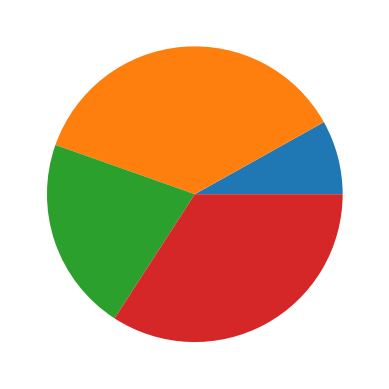

In [338]:
fig, ax = plt.subplots()
Z = np.random.uniform(0, 1, 4)
Z = 
print(Z)
ax.pie(Z)

fig.show()

In [ ]:
dw["Real_count"] = realcount(dw.Common_name,dw.Count)
#dw["Real_count"] = dw["Count"].apply(mycount, common_name = dw["Common_name"])
dw.Real_count.describe()

In [ ]:
dw.Real_count.sum()

In [ ]:
# Boxplot
plt.figure(figsize=(6,6)) # Set plot dimensions
sns.boxplot(data=dw.Real_count)

In [ ]:
# Boxplot
plt.figure(figsize=(20,5)) # Set plot dimensions
plt.xticks(rotation=-90)
sns.boxplot(data=dw, x="Common_name", y="Count")

In [ ]:
# Boxplot
plt.figure(figsize=(20,5)) # Set plot dimensions
plt.xticks(rotation=-90)
sns.boxplot(data=dw, x="Common_name", y="Real_count")

In [ ]:
# Count Plot (a.k.a. Bar Plot)
plt.figure(figsize=(25,6))
# Rotate x-labels
plt.xticks(rotation=-70)
sns.countplot(x='Common_name', data=dw)

In [ ]:
porpoise = dw[dw.Common_name == "Common Porpoise"][:]
print("Common Porpoise = ", len(porpoise))
print("Common Porpoise = ", sum(porpoise.Count))
print("Common Porpoise Real Count = ", sum(porpoise.Real_count))

In [ ]:
porpoise.head()

In [ ]:
plt.scatter(por.Date_year,dw.Count)

In [ ]:
sns.lmplot(x='Date_month', y='Count', data=porpoise,
fit_reg=False)

In [ ]:
plt.hist( dw.Date_year)

In [ ]:
plt.scatter(dw.Date_year,dw.Count)
plt.figure(figsize=(40,6))

In [ ]:
dw.Date_year.describe()

In [ ]:
dw.Real_count.describe()

In [ ]:
sns.lmplot(x='Date_year', y='Real_count', data=dw,
fit_reg=False,
hue='Common_name')
plt.figure(figsize=(20,6))